In [11]:
# Authors: Jeroen BUil
# License: BSD-3-Clause

# 3. eXplainable AI (XAI)

### About:
This notebook generates a heatmap from the model that is created in notebook 2.1_Build_CNN_Model.ipynb

## Prequisistes
If models/CNN_Model.pkl is already present, this notebook can be run directly.

If not, 2.1_Build_CNN_Model.ipynb (and for that one 1_Exploratory_Data+ANalysis) notebook must be run before this to work.
Essential file(s) are created in the subsequent steps

# Init

In [19]:
import os
import sys
import glob as glob

import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm
from IPython.display import clear_output

import torch
from captum.attr import IntegratedGradients, LayerConductance
from torchvision.transforms.functional import normalize
from torchvision import datasets, transforms
from PIL import Image


# Force add module to sys path as it is sometimes not recognised
module_path = os.path.abspath(os.path.join("..")) + "/deegtal_coding_task"
if module_path not in sys.path:
    sys.path.append(module_path)
from config import *

from model_architecture import SimpleCNN

# Load model

In [13]:
# Load model
curr_dir = os.path.abspath("")
model_path = Path(curr_dir).parent.resolve() / "models" / "CNN_Model.pkl"

model = SimpleCNN()
model.load_state_dict(torch.load(model_path, weights_only=True))

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set to eval mode
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

# XAI

In [14]:
glob.glob(str(INTERIM_DATA_DIR / f"Group{1}_Spectograms" / "*.png"))[0]

'D:\\Files\\Projects\\Code\\deegtal_coding_task\\data\\interim\\Group1_Spectograms\\group1_recording1_channel1_window1.png'

In [15]:
[
    glob.glob(str(INTERIM_DATA_DIR / f"Group{iGroup+1}_Spectograms" / "*.png"))[0]
    for iGroup in range(2)
]

['D:\\Files\\Projects\\Code\\deegtal_coding_task\\data\\interim\\Group1_Spectograms\\group1_recording1_channel1_window1.png',
 'D:\\Files\\Projects\\Code\\deegtal_coding_task\\data\\interim\\Group2_Spectograms\\group2_recording1_channel1_window1.png']

In [16]:
# Load a sample image from each class (replace with actual paths to images from Group1 and Group2)
sample_image_paths = [
    glob.glob(str(INTERIM_DATA_DIR / f"Group{iGroup+1}_Spectograms" / "*.png"))[0]
    for iGroup in range(2)
]
sample_images = [Image.open(path).convert("RGB") for path in sample_image_paths]

# Apply the same transformations as used for training
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),  # Resize images to a common size
        transforms.ToTensor(),  # Convert images to PyTorch tensor
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Transform the sample images
transformed_images = [transform(img).unsqueeze(0).to(device) for img in sample_images]

Generating heatmap for class 1


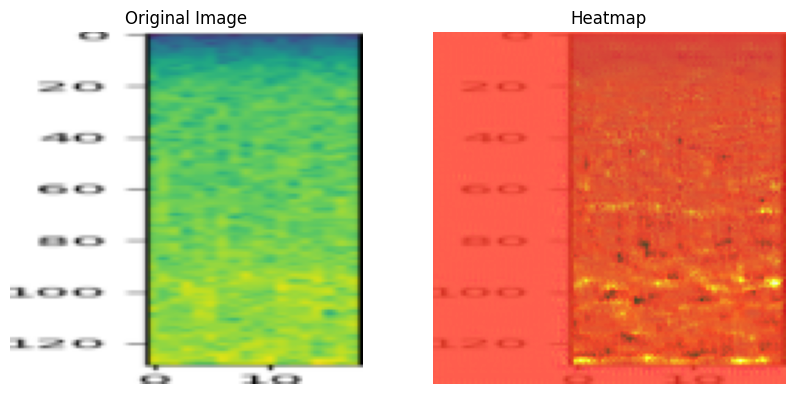

Generating heatmap for class 2


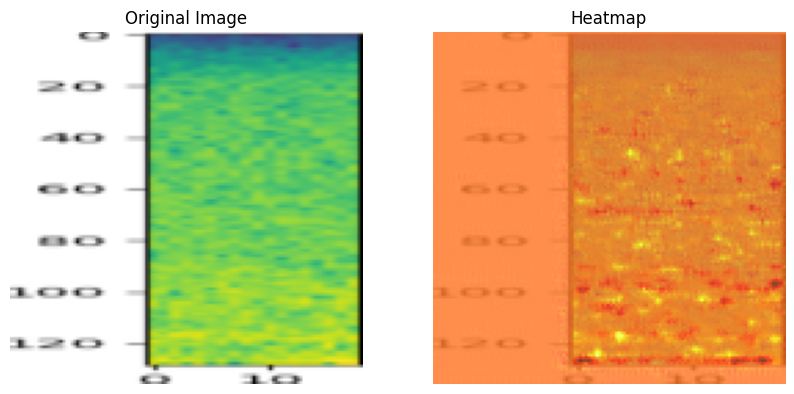

In [24]:
# Define Captum's IntegratedGradients for the model
ig = IntegratedGradients(model)


# Function to generate heatmap for a given image and class label
def generate_heatmap(model, input_image, target_class):
    # Compute attributions with IntegratedGradients
    attributions, _ = ig.attribute(input_image, target=target_class, return_convergence_delta=True)
    attributions = attributions.squeeze().cpu().detach().numpy()

    # Aggregate across color channels
    attributions = np.mean(attributions, axis=0)

    # Normalize attributions for visualization
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

    # Plot the original image and heatmap
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Original Image
    img = input_image.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    img = (img * 0.5) + 0.5  # Undo normalization for visualization
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Heatmap
    ax[1].imshow(img, alpha=0.6)
    ax[1].imshow(attributions, cmap="hot", alpha=0.7)
    ax[1].set_title("Heatmap")
    ax[1].axis("off")

    plt.show()


# Generate heatmaps for each sample image
for i, img in enumerate(transformed_images):
    print(f"Generating heatmap for class {i+1}")
    generate_heatmap(model, img, target_class=i)